```
\copy ( SELECT s.source_file_acquisition, COUNT(s.packet_id) FROM (SELECT DISTINCT source_file_acquisition, packet_id FROM spb_processing_v4_flatmap."event" WHERE source_data_type_num=1 ORDER BY source_file_acquisition ASC) AS s GROUP BY s.source_file_acquisition ORDER BY s.source_file_acquisition ASC ) TO '/mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt' with csv header delimiter as E'\t';
```

```
less /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt
less /home/spbproc/SPBDATA_flight/count_tevent_entries.txt 
cut -f1 /home/spbproc/SPBDATA_flight/count_tevent_entries.txt | head
cut -f2 /home/spbproc/SPBDATA_flight/count_tevent_entries.txt | head
cut -f2 /home/spbproc/SPBDATA_flight/count_tevent_entries.txt | head | xargs -n1 -I{} echo '{}/128' | bc
f=/home/spbproc/SPBDATA_flight/count_tevent_entries.txt; paste <(cut -f1 "$f")  <(cut -f2 "$f" | xargs -n1 -I{} echo '{}/128' | bc) | tee /home/spbproc/SPBDATA_flight/count_tevent_packets.txt
diff -y -W 400 /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt /home/spbproc/SPBDATA_flight/count_tevent_packets.txt
diff -y -W 200 /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt /home/spbproc/SPBDATA_flight/count_tevent_packets.txt | less
meld /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt /home/spbproc/SPBDATA_flight/count_tevent_packets.txt 
f=/home/spbproc/SPBDATA_flight/count_tevent_entries.txt; paste <(cut -f1 "$f" | xargs -l1 basename)  <(cut -f2 "$f" | xargs -n1 -I{} echo '{}/128' | bc) | tee /home/spbproc/SPBDATA_flight/count_sfa_tevent_packets.txt
meld /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt /home/spbproc/SPBDATA_flight/count_sfa_tevent_packets.txt 
meld /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt /home/spbproc/SPBDATA_flight/count_sfa_tevent_packets.txt 
meld <(sort -f /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt) <(sort -h /home/spbproc/SPBDATA_flight/count_sfa_tevent_packets.txt)
tail -n+2 /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt | head
meld <(tail -n+2 /mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt | sort -h) <(sort -h /home/spbproc/SPBDATA_flight/count_sfa_tevent_packets.txt)
```

In [32]:
import sys
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
import os

In [33]:
data_snippets_dir = 'flight_data_packet_count_comparison'
os.makedirs(data_snippets_dir, exist_ok=True)

In [75]:
filename_datetime_re = re.compile(
    r'(\d{4})(\d\d)(\d\d)-(\d\d)(\d\d)(\d\d)-(\d+)\.(\d+)-+(LONG|CHECK|)(-sqz(-dis)?)?\.root$')


def parse_acq_filename(infile):
    m = filename_datetime_re.search(infile)
    if m:
        bunch = int(m.group(7))
        mode = m.group(9)
        datetime_step = datetime.datetime(
            year=int(m.group(1)), month=int(m.group(2)), day=int(m.group(3)),
            hour=int(m.group(4)), minute=int(m.group(5)), second=int(m.group(6))
        )
        step_timedelta = datetime.timedelta(seconds=0)
        if mode == 'LONG':
            step_timedelta = datetime.timedelta(seconds=120)
        elif mode == 'CHECK':
            step_timedelta = datetime.timedelta(seconds=40)
        datetime_step_modified = datetime_step + step_timedelta * (bunch - 1)
        return bunch, mode, step_timedelta, datetime_step, datetime_step_modified
    return None

def parse_acq_filename_datetime_modified(infile):
    t = parse_acq_filename(infile)
    if t is None:
        return None
    else:
        return t[3]

In [76]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [77]:
db_df = pd.read_csv('/mnt/data_wdblue3d1/stuff/spb_processing_v4_flatmap_event_packet_count_by_file.txt', sep='\t')
files_df = pd.read_csv('/home/spbproc/SPBDATA_flight/count_sfa_tevent_packets.txt', sep='\t',
                       names=['source_file_acquisition', 'count'])

In [78]:
db_df['datetime'] = db_df['source_file_acquisition'].apply(parse_acq_filename_datetime_modified)
files_df['datetime'] = files_df['source_file_acquisition'].apply(parse_acq_filename_datetime_modified)

In [79]:
files_df.query('source_file_acquisition  =="allpackets-SPBEUSO-ACQUISITION-20170427-162053-001.001--.root"')

,source_file_acquisition,count,datetime
216,allpackets-SPBEUSO-ACQUISITION-20170427-162053-001.001--.root,5,2017-04-27 16:20:53


In [188]:
# =="allpackets-SPBEUSO-ACQUISITION-20170427-162053-001.001--.root"
files_df[files_df['datetime'].isnull()]

,source_file_acquisition,count,datetime


In [189]:
db_df.head()

,source_file_acquisition,count,datetime
0,allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root,4,2017-04-24 15:01:43
1,allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root,21,2017-04-24 15:02:28
2,allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root,26,2017-04-24 15:02:28
3,allpackets-SPBEUSO-ACQUISITION-20170424-150228-003.001--LONG.root,32,2017-04-24 15:02:28
4,allpackets-SPBEUSO-ACQUISITION-20170424-150228-004.001--LONG.root,26,2017-04-24 15:02:28


In [190]:
files_df.head()

,source_file_acquisition,count,datetime
0,allpackets-SPBEUSO-ACQUISITION-20170420-135400-001.001--CHECK.root,219,2017-04-20 13:54:00
1,allpackets-SPBEUSO-ACQUISITION-20170420-135444-006.001--LONG.root,86,2017-04-20 13:54:44
2,allpackets-SPBEUSO-ACQUISITION-20170420-135444-002.001--LONG.root,304,2017-04-20 13:54:44
3,allpackets-SPBEUSO-ACQUISITION-20170420-160440-001.001--LONG.root,110,2017-04-20 16:04:40
4,allpackets-SPBEUSO-ACQUISITION-20170420-160356-001.001--CHECK.root,34,2017-04-20 16:03:56


In [191]:
merged_df = pd.merge(db_df, files_df, on='source_file_acquisition', how='outer', indicator=True, 
                     suffixes=('_in_db', '_in_files'))

In [192]:
merged_df.head()

,source_file_acquisition,count_in_db,datetime_in_db,count_in_files,datetime_in_files,_merge
0,allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root,4.0,2017-04-24 15:01:43,13,2017-04-24 15:01:43,both
1,allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root,21.0,2017-04-24 15:02:28,76,2017-04-24 15:02:28,both
2,allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root,26.0,2017-04-24 15:02:28,69,2017-04-24 15:02:28,both
3,allpackets-SPBEUSO-ACQUISITION-20170424-150228-003.001--LONG.root,32.0,2017-04-24 15:02:28,83,2017-04-24 15:02:28,both
4,allpackets-SPBEUSO-ACQUISITION-20170424-150228-004.001--LONG.root,26.0,2017-04-24 15:02:28,76,2017-04-24 15:02:28,both


## Database - filesystem: Same counts 

In [193]:
same_counts_df =  merged_df.query('count_in_db == count_in_files')

In [194]:
same_counts_df

,source_file_acquisition,count_in_db,datetime_in_db,count_in_files,datetime_in_files,_merge
41,allpackets-SPBEUSO-ACQUISITION-20170425-122821-001.001--LONG.root,21.0,2017-04-25 12:28:21,21,2017-04-25 12:28:21,both
42,allpackets-SPBEUSO-ACQUISITION-20170425-122850-001.001--LONG.root,14.0,2017-04-25 12:28:50,14,2017-04-25 12:28:50,both
44,allpackets-SPBEUSO-ACQUISITION-20170425-123151-001.001--CHECK.root,26.0,2017-04-25 12:31:51,26,2017-04-25 12:31:51,both
52,allpackets-SPBEUSO-ACQUISITION-20170426-125845-001.001--CHECK.root,12.0,2017-04-26 12:58:45,12,2017-04-26 12:58:45,both
53,allpackets-SPBEUSO-ACQUISITION-20170426-125930-001.001--LONG.root,34.0,2017-04-26 12:59:30,34,2017-04-26 12:59:30,both
54,allpackets-SPBEUSO-ACQUISITION-20170426-125930-002.001--LONG.root,41.0,2017-04-26 12:59:30,41,2017-04-26 12:59:30,both
55,allpackets-SPBEUSO-ACQUISITION-20170426-125930-003.001--LONG.root,53.0,2017-04-26 12:59:30,53,2017-04-26 12:59:30,both
56,allpackets-SPBEUSO-ACQUISITION-20170426-125930-004.001--LONG.root,36.0,2017-04-26 12:59:30,36,2017-04-26 12:59:30,both
244,allpackets-SPBEUSO-ACQUISITION-20170427-162053-001.001--.root,5.0,2017-04-27 16:20:53,5,2017-04-27 16:20:53,both
245,allpackets-SPBEUSO-ACQUISITION-20170428-063224-001.001--LONG.root,7.0,2017-04-28 06:32:24,7,2017-04-28 06:32:24,both


In [195]:
len(same_counts_df)

91

## Database - filesystem: Different counts 

In [196]:
different_counts_df = merged_df.query('count_in_db != count_in_files and _merge=="both"').copy()

In [197]:
different_counts_df['count_difference'] = (different_counts_df['count_in_files'] - different_counts_df['count_in_db'])

In [198]:
len(different_counts_df)

947

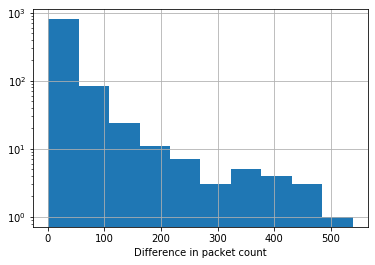

In [199]:
fig, ax = plt.subplots()
different_counts_df['count_difference'].hist(ax=ax)
ax.set_xlabel('Difference in packet count')
ax.set_yscale('log')
plt.show()

In [200]:
different_counts_df.sort_values('count_difference', ascending=False).head(200)

,source_file_acquisition,count_in_db,datetime_in_db,count_in_files,datetime_in_files,_merge,count_difference
197,allpackets-SPBEUSO-ACQUISITION-20170427-125407-005.001--LONG-sqz-dis.root,48.0,2017-04-27 12:54:07,586,2017-04-27 12:54:07,both,538.0
107,allpackets-SPBEUSO-ACQUISITION-20170427-082554-002.001--LONG-sqz.root,776.0,2017-04-27 08:25:54,1224,2017-04-27 08:25:54,both,448.0
106,allpackets-SPBEUSO-ACQUISITION-20170427-082554-001.001--LONG-sqz.root,761.0,2017-04-27 08:25:54,1203,2017-04-27 08:25:54,both,442.0
108,allpackets-SPBEUSO-ACQUISITION-20170427-082554-003.001--LONG-sqz.root,714.0,2017-04-27 08:25:54,1149,2017-04-27 08:25:54,both,435.0
110,allpackets-SPBEUSO-ACQUISITION-20170427-082554-005.001--LONG-sqz.root,735.0,2017-04-27 08:25:54,1135,2017-04-27 08:25:54,both,400.0
112,allpackets-SPBEUSO-ACQUISITION-20170427-082554-007.001--LONG-sqz.root,583.0,2017-04-27 08:25:54,982,2017-04-27 08:25:54,both,399.0
114,allpackets-SPBEUSO-ACQUISITION-20170427-082554-008.001--LONG-sqz.root,614.0,2017-04-27 08:25:54,1008,2017-04-27 08:25:54,both,394.0
116,allpackets-SPBEUSO-ACQUISITION-20170427-082554-010.001--LONG-sqz.root,639.0,2017-04-27 08:25:54,1016,2017-04-27 08:25:54,both,377.0
109,allpackets-SPBEUSO-ACQUISITION-20170427-082554-004.001--LONG-sqz.root,667.0,2017-04-27 08:25:54,1041,2017-04-27 08:25:54,both,374.0
111,allpackets-SPBEUSO-ACQUISITION-20170427-082554-006.001--LONG-sqz.root,659.0,2017-04-27 08:25:54,1030,2017-04-27 08:25:54,both,371.0


In [201]:
different_counts_df['count_difference'].sum() 

28901.0

## Database - filesystem: Only database

In [202]:
only_db_counts_df = merged_df.query('_merge=="left_only"')

In [203]:
len(only_db_counts_df)

0

## Database - filesystem: Only filesystem

In [204]:
only_files_counts_df = merged_df.query('_merge=="right_only"')

In [205]:
len(only_files_counts_df)

51

In [206]:
only_files_counts_df

,source_file_acquisition,count_in_db,datetime_in_db,count_in_files,datetime_in_files,_merge
1038,allpackets-SPBEUSO-ACQUISITION-20170420-135400-001.001--CHECK.root,NaN,NaT,219,2017-04-20 13:54:00,right_only
1039,allpackets-SPBEUSO-ACQUISITION-20170420-135444-006.001--LONG.root,NaN,NaT,86,2017-04-20 13:54:44,right_only
1040,allpackets-SPBEUSO-ACQUISITION-20170420-135444-002.001--LONG.root,NaN,NaT,304,2017-04-20 13:54:44,right_only
1041,allpackets-SPBEUSO-ACQUISITION-20170420-160440-001.001--LONG.root,NaN,NaT,110,2017-04-20 16:04:40,right_only
1042,allpackets-SPBEUSO-ACQUISITION-20170420-160356-001.001--CHECK.root,NaN,NaT,34,2017-04-20 16:03:56,right_only
1043,allpackets-SPBEUSO-ACQUISITION-20170420-160440-002.001--LONG.root,NaN,NaT,101,2017-04-20 16:04:40,right_only
1044,allpackets-SPBEUSO-ACQUISITION-20170421-135909-001.001--CHECK.root,NaN,NaT,306,2017-04-21 13:59:09,right_only
1045,allpackets-SPBEUSO-ACQUISITION-20170425-122842-001.001--CHECK.root,NaN,NaT,1,2017-04-25 12:28:42,right_only
1046,allpackets-SPBEUSO-ACQUISITION-20170425-122743-001.001--CHECK.root,NaN,NaT,1,2017-04-25 12:27:43,right_only
1047,allpackets-SPBEUSO-ACQUISITION-20170425-122750-001.001--LONG.root,NaN,NaT,1,2017-04-25 12:27:50,right_only


every packet everything exactly same sequence, nothing triggered
- allpackets-SPBEUSO-ACQUISITION-20170420-160356-001.001--CHECK.root	
- allpackets-SPBEUSO-ACQUISITION-20170420-160440-002.001--LONG.root	
- allpackets-SPBEUSO-ACQUISITION-20170421-135909-001.001--CHECK.root
- allpackets-SPBEUSO-ACQUISITION-20170429-100343-003.001--LONG-sqz.root
- allpackets-SPBEUSO-ACQUISITION-20170429-100343-003.001--LONG-sqz.root
- allpackets-SPBEUSO-ACQUISITION-20170429-070031-007.001--LONG-sqz.root
- allpackets-SPBEUSO-ACQUISITION-20170427-105159-010.001--LONG-sqz.root
- allpackets-SPBEUSO-ACQUISITION-20170429-100343-003.001--LONG-sqz.root
- allpackets-SPBEUSO-ACQUISITION-20170429-070031-003.001--LONG-sqz.root

not processed
- allpackets-SPBEUSO-ACQUISITION-20170421-135909-001.001--CHECK.root
- allpackets-SPBEUSO-ACQUISITION-20170426-160158-001.001--CHECK.root
- allpackets-SPBEUSO-ACQUISITION-20170427-125407-005.001--LONG-sqz.root
- allpackets-SPBEUSO-ACQUISITION-20170427-125407-006.001--LONG-sqz.root
- allpackets-SPBEUSO-ACQUISITION-20170427-125407-006.001--LONG-sqz-dis.root
- allpackets-SPBEUSO-ACQUISITION-20170427-125407-007.001--LONG-sqz.root
- allpackets-SPBEUSO-ACQUISITION-20170427-125407-007.001--LONG-sqz-dis.root	

In [207]:
only_files_counts_df['count_in_files'].sum()

3348

## Non-processed packets

In [208]:
num_non_processed_packets = \
    different_counts_df['count_difference'].sum() + only_files_counts_df['count_in_files'].sum()

In [209]:
num_non_processed_packets

32249.0

In [210]:
files_df['count'].sum()

177897

In [211]:
num_non_processed_packets / files_df['count'].sum()

0.18127905473391906

## Counts

In [212]:
print('Num all packets in files   ', files_df['count'].sum())
print('Num all packets in database', db_df['count'].sum())

Num all packets in files    177897
Num all packets in database 145648


In [213]:
starting_datetime = datetime.datetime(year=2017, month=4, day=25)

print('Num packets in files   ', files_df[files_df['datetime'] > starting_datetime]['count'].sum())
print('Num packets in database', db_df[db_df['datetime'] > starting_datetime]['count'].sum())

Num packets in files    175994
Num packets in database 145412


In [214]:
 files_df[files_df['datetime'] > starting_datetime]['count'].sum() * 128 * 2.5 * 10**(-6)

56.318079999999995

## Distributions

In [215]:
hist_date_range = (min(files_df['datetime'].min(), db_df['datetime'].min()), 
                   max(files_df['datetime'].max(), db_df['datetime'].max()))

In [216]:
hist_date_range

(Timestamp('2017-04-20 13:54:00'), Timestamp('2017-05-06 12:39:12'))

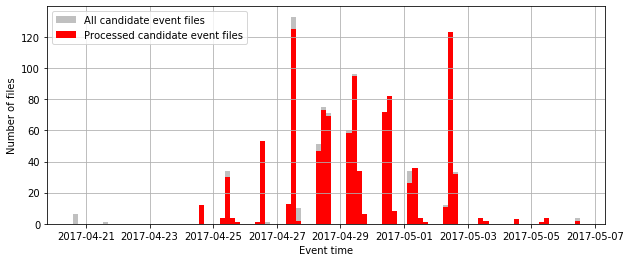

In [217]:
fig, ax = plt.subplots(figsize=(10,4))
files_df['datetime'].hist(ax=ax, bins=100, range=hist_date_range, color='silver', label='All candidate event files')
db_df['datetime'].hist(ax=ax, bins=100, range=hist_date_range, color='red', label='Processed candidate event files')
# ax.set_yscale('log')
ax.set_ylabel('Number of files')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'num_file_distribition_date_linear.svg'))
plt.show()

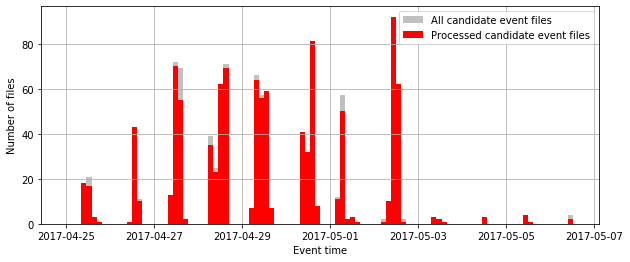

In [218]:
starting_datetime = datetime.datetime(year=2017, month=4, day=25)
hist_range_modified = (starting_datetime, hist_date_range[1])

fig, ax = plt.subplots(figsize=(10,4))
files_df[files_df['datetime'] >= starting_datetime]['datetime'].hist(ax=ax, bins=100, range=hist_range_modified, color='silver', label='All candidate event files')
db_df[db_df['datetime'] >= starting_datetime]['datetime'].hist(ax=ax, bins=100, range=hist_range_modified, color='red', label='Processed candidate event files')
# ax.set_yscale('log')
ax.set_ylabel('Number of files')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'num_file_distribition_date_linear_from_20170425.svg'))
plt.show()

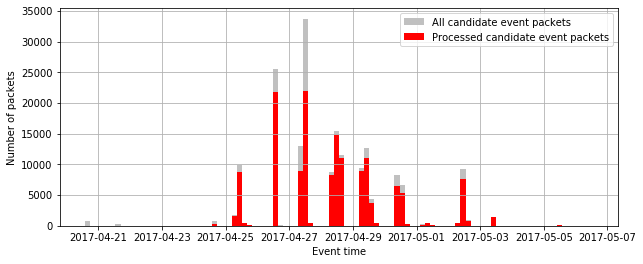

In [219]:
fig, ax = plt.subplots(figsize=(10,4))
files_df['datetime'].hist(ax=ax, weights=files_df['count'], bins=100, range=hist_date_range, color='silver', label='All candidate event packets')
db_df['datetime'].hist(ax=ax, weights=db_df['count'], bins=100, range=hist_date_range, color='red', label='Processed candidate event packets')
# ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'packet_distribition_date_linear.svg'))
plt.show()

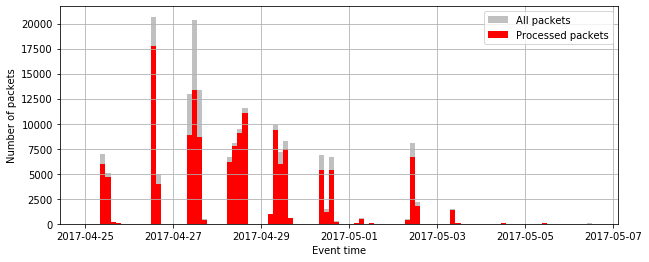

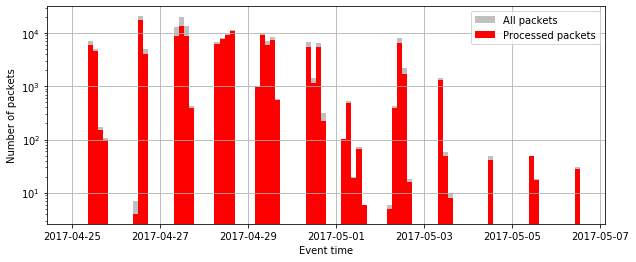

In [220]:
starting_datetime = datetime.datetime(year=2017, month=4, day=25)
hist_range_modified = (starting_datetime, hist_date_range[1])

for scale in ['linear', 'log']:
    fig, ax = plt.subplots(figsize=(10,4))
    files_df['datetime'].hist(ax=ax, weights=files_df['count'], bins=100, range=hist_range_modified, color='silver', label='All packets')
    db_df['datetime'].hist(ax=ax, weights=db_df['count'], bins=100, range=hist_range_modified, color='red', label='Processed packets')
    ax.set_yscale(scale)
    ax.set_ylabel('Number of packets')
    ax.set_xlabel('Event time')
    ax.legend()
    fig.savefig(os.path.join(data_snippets_dir, 'packet_distribition_date_'+scale+'_from_20170425.svg'))
    plt.show()

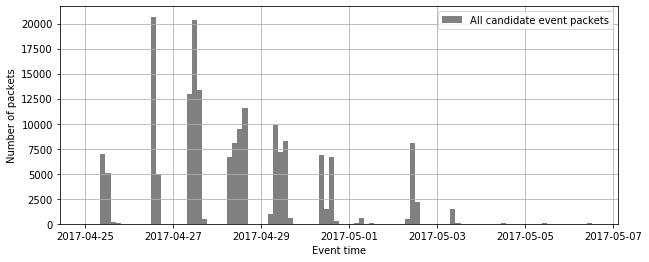

In [221]:
starting_datetime = datetime.datetime(year=2017, month=4, day=25)
hist_range_modified = (starting_datetime, hist_date_range[1])

subset_df = files_df[files_df['datetime'] > starting_datetime]

fig, ax = plt.subplots(figsize=(10,4))
subset_df['datetime'].hist(ax=ax, weights=subset_df['count'], bins=100, range=hist_range_modified, color='gray', label='All candidate event packets')
# db_df['datetime'].hist(ax=ax, weights=db_df['count'], bins=100, range=hist_range_modified, color='red', label='Processed candidate event packets')
# ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'files_packet_distribition_date_linear_from_20170425.svg'))
plt.show()

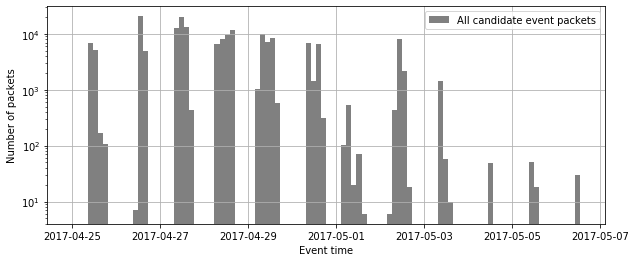

In [222]:
starting_datetime = datetime.datetime(year=2017, month=4, day=25)
hist_range_modified = (starting_datetime, hist_date_range[1])

subset_df = files_df[files_df['datetime'] > starting_datetime]

fig, ax = plt.subplots(figsize=(10,4))
subset_df['datetime'].hist(ax=ax, weights=subset_df['count'], bins=100, range=hist_range_modified, color='gray', label='All candidate event packets')
# db_df['datetime'].hist(ax=ax, weights=db_df['count'], bins=100, range=hist_range_modified, color='red', label='Processed candidate event packets')
ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'files_packet_distribition_date_log_from_20170425.svg'))
plt.show()

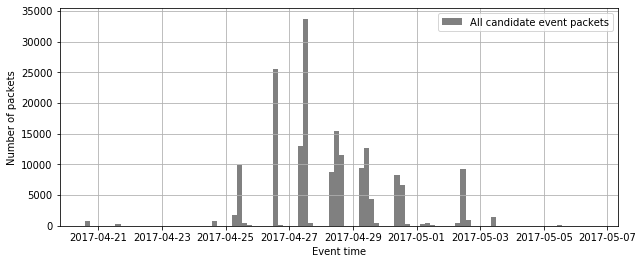

In [223]:
fig, ax = plt.subplots(figsize=(10,4))
files_df['datetime'].hist(ax=ax, weights=files_df['count'], bins=100, range=hist_date_range, color='gray', label='All candidate event packets')
# db_df['datetime'].hist(ax=ax, weights=db_df['count'], bins=100, range=hist_range_modified, color='red', label='Processed candidate event packets')
# ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir, 'files_packet_distribition_date_linear.svg'))
plt.show()

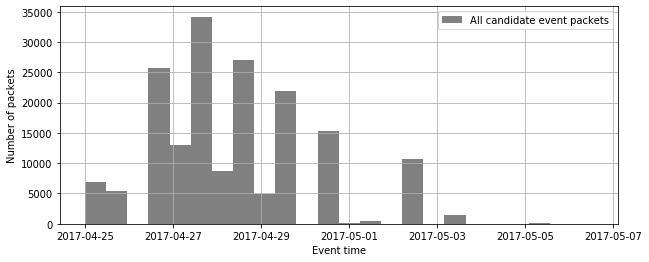

In [224]:
starting_datetime = datetime.datetime(year=2017, month=4, day=25)
hist_range_modified = (starting_datetime, hist_date_range[1])

subset_df = files_df[files_df['datetime'] > starting_datetime]

fig, ax = plt.subplots(figsize=(10,4))
subset_df['datetime'].hist(ax=ax, weights=subset_df['count'], bins=24, range=hist_range_modified, color='gray', label='All candidate event packets')
# db_df['datetime'].hist(ax=ax, weights=db_df['count'], bins=100, range=hist_range_modified, color='red', label='Processed candidate event packets')
# ax.set_yscale('log')
ax.set_ylabel('Number of packets')
ax.set_xlabel('Event time')
ax.legend()
# fig.savefig(os.path.join(data_snippets_dir, 'files_packet_distribition_date_log_from_20170425.svg'))
plt.show()